In [1]:
import sys
import javalang
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as tick

import numpy as np
import pandas as pd
import tensorflow as tf

from collections import Counter

from tqdm import tqdm
tqdm.pandas()

plt.rcParams['figure.figsize'] = (15, 10)

/home/tony/source/identifier-suggestion/.venv/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
sys.path.append('..')

In [3]:
from src.preprocessing.tokens import tokenize_method, split_subtokens
from src.utils.pandas import lists_to_series

In [4]:
!ls -la ../data/interim/repositories/

total 449148
drwxr-xr-x 2 tony tony     4096 Jun 13 15:32 .
drwxr-xr-x 6 tony tony     4096 Jun 13 17:39 ..
-rw-r--r-- 1 tony tony  2189109 Jun  8 19:45 antlr4.csv
-rw-r--r-- 1 tony tony 31264895 Jun  8 19:50 bazel.csv
-rw-r--r-- 1 tony tony  4002518 Jun  8 19:50 bigbluebutton.csv
-rw-r--r-- 1 tony tony  1581338 Jun  8 19:52 clojure.csv
-rw-r--r-- 1 tony tony  1895700 Jun  8 19:44 commons-io.csv
-rw-r--r-- 1 tony tony  5353107 Jun  8 19:51 commons-lang.csv
-rw-r--r-- 1 tony tony 13547341 Jun  8 19:49 dbeaver.csv
-rw-r--r-- 1 tony tony  6803490 Jun  8 19:47 dubbo.csv
-rw-r--r-- 1 tony tony 74709070 Jun  8 20:00 elasticsearch.csv
-rw-r--r-- 1 tony tony  6303665 Jun  8 19:45 ExoPlayer.csv
-rw-r--r-- 1 tony tony 41721105 Jun  8 19:51 flink.csv
-rw-r--r-- 1 tony tony 37672417 Jun  8 19:54 graal.csv
-rw-r--r-- 1 tony tony  9349965 Jun  8 19:46 groovy.csv
-rw-r--r-- 1 tony tony  1027063 Jun  8 19:53 gson.csv
-rw-r--r-- 1 tony tony 23200188 Jun  8 19:51 guava.csv
-rw-r--r-- 1 tony tony 7785005

In [5]:
%%bash
# if the combined raw CSV file is created, do not create it again
[ -f '../data/interim/all.csv' ] && exit 0

# prepend the CSV header with column names
head -n 1 ../data/interim/repositories/antlr4.csv >> ../data/interim/all.csv

for f in ../data/interim/repositories/*; do
    tail -n +2 "$f" >> '../data/interim/all.csv'
    echo "added $f"
done

In [6]:
!wc -l ../data/interim/all.csv

792035 ../data/interim/all.csv


In [7]:
csv_filename = '../data/interim/all.csv'

max_input_vocab_size=30000

In [8]:
# Reading the input files
df = pd.read_csv(csv_filename, encoding='utf8')

df.head()

,file_name,class_name,method_name,return_type,arguments,body,documentation,modifiers,annotations
0,../external/repositories/antlr4/doc/resources/...,CaseChangingCharStream,getText,String,"[['interval', 'Interval']]",{ return stream.getText(interval); },None,['public'],['Override']
1,../external/repositories/antlr4/doc/resources/...,CaseChangingCharStream,consume,void,[],{ stream.consume(); },None,['public'],['Override']
2,../external/repositories/antlr4/doc/resources/...,CaseChangingCharStream,LA,int,"[['i', 'int']]",{ int c = stream.LA(i); if (c <= 0) { return c...,None,['public'],['Override']
3,../external/repositories/antlr4/doc/resources/...,CaseChangingCharStream,mark,int,[],{ return stream.mark(); },None,['public'],['Override']
4,../external/repositories/antlr4/doc/resources/...,CaseChangingCharStream,release,void,"[['marker', 'int']]",{ stream.release(marker); },None,['public'],['Override']


In [9]:
# Cleaning, filtering the data
df = df.dropna()
len(df)

791986

In [10]:
def tokenize_and_aggregate(code_series, tokenizer_fn=None):
    tokenized_series = code_series.progress_apply(tokenizer_fn) if tokenizer_fn else code_series

    sequence_lengths = tokenized_series.progress_apply(len)
    
    unique_token_counts = pd.DataFrame.from_dict(Counter(lists_to_series(tokenized_series).values), orient='index') \
        .sort_values(by=0, ascending=False) \
        .reset_index().rename(columns={'index': 'token', 0: 'count'})

    return sequence_lengths, unique_token_counts

In [11]:
def cumsum_plot(series, labels):
    if len(series) < 1:
        raise AttributeError('At least one series must be given')
    
    if len(series) != len(labels):
        raise AttributeError('The given series and labels must have equal lengths')
    
    plots_points = [
        (serie.cumsum() / serie.sum())
        for serie in series
    ]
    
    max_seq_len = np.max([len(s) for s in series])
    xs = np.linspace(0, max_seq_len, 10)

    for plot_points in plots_points:
        plt.semilogx(range(len(plot_points)), plot_points) #, drawstyle='steps')

    plt.grid(True)
        
    plt.gca().xaxis.set_major_formatter(tick.StrMethodFormatter('{x:,.0f}'))
    plt.xticks([2 ** x for x in range(math.ceil(math.log(max_seq_len, 2)))], fontsize=14, rotation=-45)
    
    plt.yticks(np.arange(0, 1.01, step=0.05), fontsize=14)
    
    plt.legend(labels=labels, fontsize=18, loc='lower right')

In [12]:
def quantile_plot(series, labels):
    if len(series) < 1:
        raise AttributeError('At least one series must be given')
    
    if len(series) != len(labels):
        raise AttributeError('The given series and labels must have equal lengths')
    
    plots_points = [
        [
            (x / 100, serie.quantile(x / 100))
            for x in range(0, 100, 5)
        ]
        for serie in series
    ]
    
    xs = [t[0] for t in plots_points[0]]
    
    print(f'Analyzing {len(xs)} quantiles: {xs}')
    
    max_y = 0
    
    for plot_points in plots_points:
        ys = [t[1] for t in plot_points]
        max_y = max(max_y, np.max(ys))
        plt.plot(xs, ys, drawstyle='steps-mid')
    
    plt.xticks(xs, fontsize=14)
    plt.yticks(np.linspace(0, max_y, 20), fontsize=14)
    plt.grid(True)
    plt.legend(labels=labels, fontsize=18)

In [13]:
token_level_seq_lengths, token_level_vocab = tokenize_and_aggregate(
    df['body'],
    tokenizer_fn=lambda method: tokenize_method(method, subtoken_level=False)
)

 14%|█▍        | 114740/791986 [00:24<02:16, 4965.36it/s]

ERROR in tokenizing: {packagesToScan}") String... packagesToScan) return new ServiceClassPostProcessor(packagesToScan); }


 58%|█████▊    | 458758/791986 [01:53<01:06, 5023.25it/s]

ERROR in tokenizing: {logFile : .+}") public void parseFile( @PathParam("logFile") String logFile) throws IOException, SkylineStoreException, ResourceEstimatorException { logParserUtil.parseLog(logFile); LOGGER.debug("Parse logFile: {}.", logFile); }


 93%|█████████▎| 737295/791986 [02:57<00:16, 3257.67it/s] 

ERROR in tokenizing: {systemProperties.systemProperty}") int param1, @Value("#{request.contextPath}") String param2, String notSupported) { }


 94%|█████████▍| 744525/791986 [02:59<00:18, 2596.33it/s]

ERROR in tokenizing: {foo}") String foo) return null; }


 95%|█████████▌| 755010/791986 [03:02<00:08, 4257.93it/s]

ERROR in tokenizing: {systemProperties[myProp]}") Provider<String> name) return new TestBean(name.get()); }
ERROR in tokenizing: {systemProperties[myProp]}") Provider<String> name2) return new TestBean(name2.get()); }


 95%|█████████▌| 756305/791986 [03:02<00:06, 5168.46it/s]

ERROR in tokenizing: {privateInstance.age}") String country) TestBean tb = new TestBean("protectedInstance", 1); tb.setSpouse(tb); tb.setCountry(country); return tb; }


 97%|█████████▋| 771045/791986 [03:05<00:03, 5535.98it/s]

ERROR in tokenizing: {enigma}") Integer enigmaParam) assertThat(enigmaParam).as("Enigma should have been injected via @Value by Spring").isNotNull(); assertThat(enigmaParam).as("enigma").isEqualTo(42); }
ERROR in tokenizing: {bogus:false}") Boolean defaultValue) assertThat(defaultValue).as("Default value should have been injected via @Value by Spring").isNotNull(); assertThat(defaultValue).as("default value").isEqualTo(false); }
ERROR in tokenizing: {@dilbert.name}") String name) assertThat(name).as("Dilbert's name should have been injected via SpEL expression in @Value by Spring").isNotNull(); assertThat(name).as("name from SpEL expression").isEqualTo("Dilbert"); }
ERROR in tokenizing: {enigma}") Integer enigmaParam) assertThat(enigmaParam).as("Enigma should have been injected via @Value by Spring").isNotNull(); assertThat(enigmaParam).as("enigma").isEqualTo(42); }
ERROR in tokenizing: {bogus:false}") Boolean defaultValue) assertThat(defaultValue).as("Default value should have been in

 98%|█████████▊| 776120/791986 [03:06<00:04, 3500.61it/s]

ERROR in tokenizing: {myKey}") String id, @RequestHeader(defaultValue = "#{systemProperties.myHeader}") String header, @Value("#{request.contextPath}") String contextPath, HttpServletResponse response) throws IOException { response.getWriter().write(String.valueOf(id) + "-" + String.valueOf(header) + "-" + contextPath); }


100%|██████████| 791986/791986 [00:00<00:00, 1345907.41it/s]


In [15]:
char_level_seq_lengths, char_level_vocab = tokenize_and_aggregate(df['body'], tokenizer_fn=None)

100%|██████████| 791986/791986 [00:00<00:00, 1131011.72it/s]


In [16]:
subtoken_level_seq_lengths, subtoken_level_vocab = tokenize_and_aggregate(df['body'], tokenizer_fn=tokenize_method)

 14%|█▍        | 114659/791986 [00:27<02:39, 4254.33it/s]

ERROR in tokenizing: {packagesToScan}") String... packagesToScan) return new ServiceClassPostProcessor(packagesToScan); }


 58%|█████▊    | 458476/791986 [02:08<01:08, 4843.20it/s]

ERROR in tokenizing: {logFile : .+}") public void parseFile( @PathParam("logFile") String logFile) throws IOException, SkylineStoreException, ResourceEstimatorException { logParserUtil.parseLog(logFile); LOGGER.debug("Parse logFile: {}.", logFile); }


 93%|█████████▎| 737241/791986 [03:21<00:18, 2944.10it/s] 

ERROR in tokenizing: {systemProperties.systemProperty}") int param1, @Value("#{request.contextPath}") String param2, String notSupported) { }


 94%|█████████▍| 744442/791986 [03:22<00:10, 4700.86it/s]

ERROR in tokenizing: {foo}") String foo) return null; }


 95%|█████████▌| 754840/791986 [03:25<00:13, 2849.79it/s]

ERROR in tokenizing: {systemProperties[myProp]}") Provider<String> name) return new TestBean(name.get()); }
ERROR in tokenizing: {systemProperties[myProp]}") Provider<String> name2) return new TestBean(name2.get()); }


 95%|█████████▌| 756091/791986 [03:26<00:10, 3500.49it/s]

ERROR in tokenizing: {privateInstance.age}") String country) TestBean tb = new TestBean("protectedInstance", 1); tb.setSpouse(tb); tb.setCountry(country); return tb; }


 97%|█████████▋| 771093/791986 [03:30<00:04, 4800.36it/s]

ERROR in tokenizing: {enigma}") Integer enigmaParam) assertThat(enigmaParam).as("Enigma should have been injected via @Value by Spring").isNotNull(); assertThat(enigmaParam).as("enigma").isEqualTo(42); }
ERROR in tokenizing: {bogus:false}") Boolean defaultValue) assertThat(defaultValue).as("Default value should have been injected via @Value by Spring").isNotNull(); assertThat(defaultValue).as("default value").isEqualTo(false); }
ERROR in tokenizing: {@dilbert.name}") String name) assertThat(name).as("Dilbert's name should have been injected via SpEL expression in @Value by Spring").isNotNull(); assertThat(name).as("name from SpEL expression").isEqualTo("Dilbert"); }
ERROR in tokenizing: {enigma}") Integer enigmaParam) assertThat(enigmaParam).as("Enigma should have been injected via @Value by Spring").isNotNull(); assertThat(enigmaParam).as("enigma").isEqualTo(42); }
ERROR in tokenizing: {bogus:false}") Boolean defaultValue) assertThat(defaultValue).as("Default value should have been in

 98%|█████████▊| 775986/791986 [03:31<00:05, 2680.25it/s]

ERROR in tokenizing: {myKey}") String id, @RequestHeader(defaultValue = "#{systemProperties.myHeader}") String header, @Value("#{request.contextPath}") String contextPath, HttpServletResponse response) throws IOException { response.getWriter().write(String.valueOf(id) + "-" + String.valueOf(header) + "-" + contextPath); }


100%|██████████| 791986/791986 [00:00<00:00, 1329395.65it/s]


Analyzing 20 quantiles: [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]


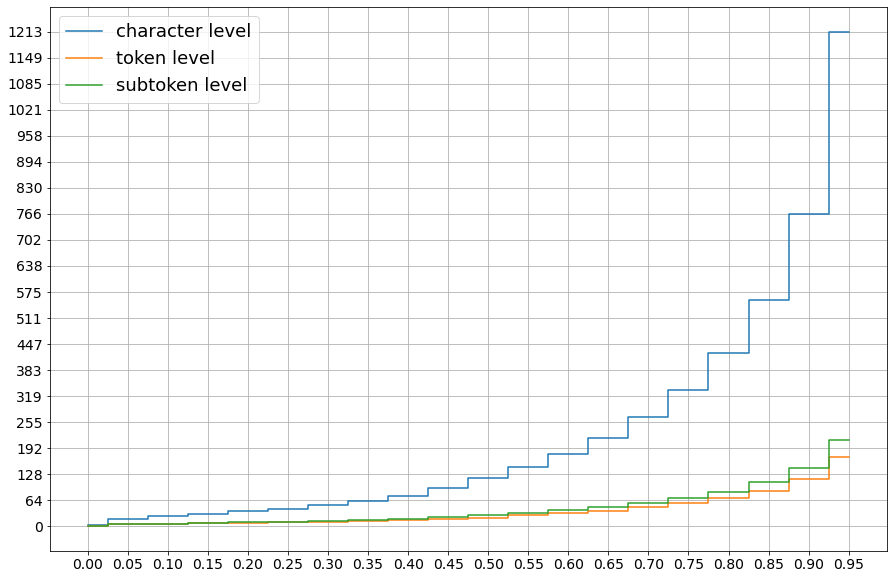

In [17]:
quantile_plot([
    char_level_seq_lengths,
    token_level_seq_lengths,
    subtoken_level_seq_lengths,
], labels=[
    'character level',
    'token level',
    'subtoken level',
])

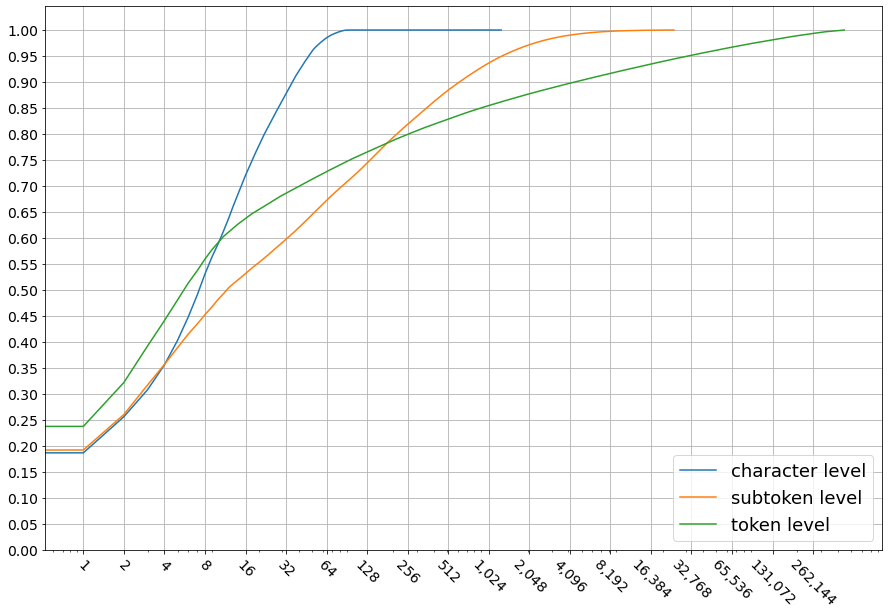

In [18]:
cumsum_plot([
    char_level_vocab['count'],
    subtoken_level_vocab['count'],
    token_level_vocab['count']
], labels=[
    'character level',
    'subtoken level',
    'token level'
])

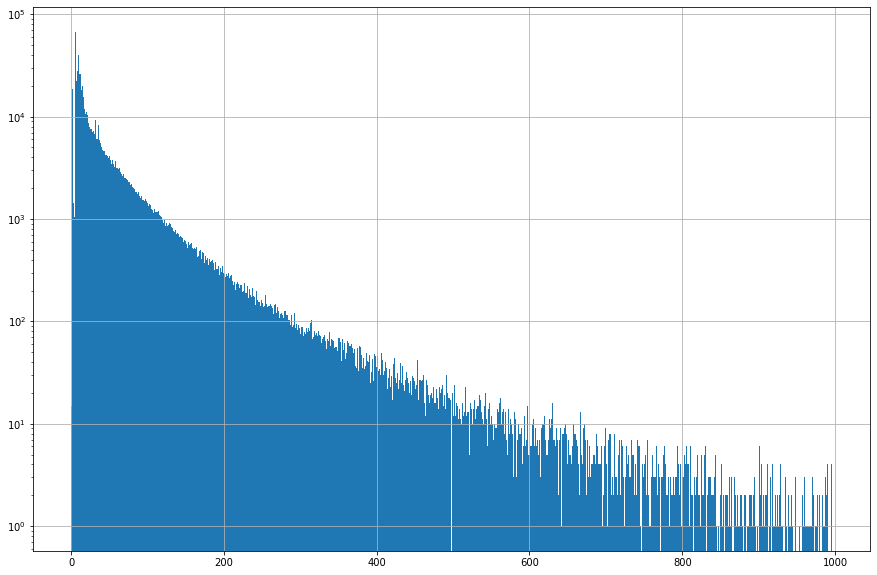

In [19]:
token_level_seq_lengths[token_level_seq_lengths < 1000].hist(bins=1000, log=True)

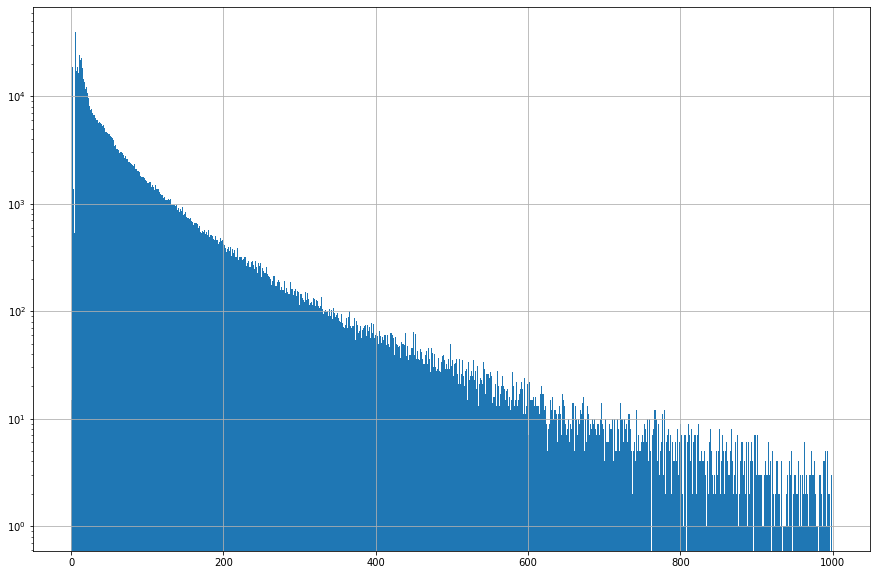

In [20]:
subtoken_level_seq_lengths[subtoken_level_seq_lengths < 1000].hist(bins=1000, log=True)

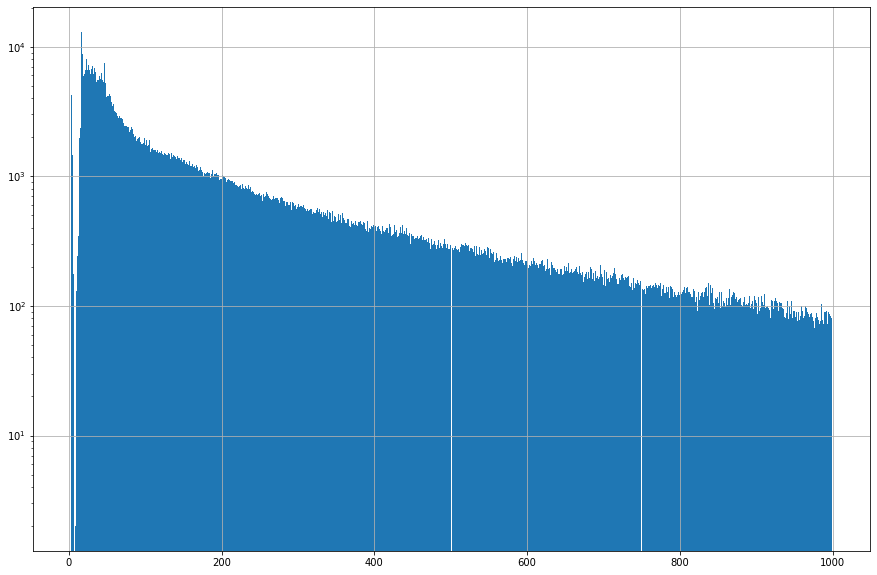

In [21]:
char_level_seq_lengths[char_level_seq_lengths < 1000].hist(bins=1000, log=True)

In [10]:
code = df[df.body.str.contains('0x')]['body'].values[1]
code

'{ IntegerList l = new IntegerList(); l.add(0x110000); thrown.expect(IllegalArgumentException.class); l.toCharArray(); }'

In [29]:
import javalang

for id, token in enumerate(list(javalang.tokenizer.tokenize(code))):
    print(id, token, type(token) == javalang.tokenizer.Literal)

0 Separator "{" line 1, position 1 False
1 Identifier "IntegerList" line 1, position 3 False
2 Identifier "l" line 1, position 15 False
3 Operator "=" line 1, position 17 False
4 Keyword "new" line 1, position 19 False
5 Identifier "IntegerList" line 1, position 23 False
6 Separator "(" line 1, position 34 False
7 Separator ")" line 1, position 35 False
8 Separator ";" line 1, position 36 False
9 Identifier "l" line 1, position 38 False
10 Separator "." line 1, position 39 False
11 Identifier "add" line 1, position 40 False
12 Separator "(" line 1, position 43 False
13 HexInteger "0x110000" line 1, position 44 False
14 Separator ")" line 1, position 52 False
15 Separator ";" line 1, position 53 False
16 Identifier "thrown" line 1, position 55 False
17 Separator "." line 1, position 61 False
18 Identifier "expect" line 1, position 62 False
19 Separator "(" line 1, position 68 False
20 Identifier "IllegalArgumentException" line 1, position 69 False
21 Separator "." line 1, position 93 Fa

In [10]:
print(df[df.index == 301881]['body'].values[0])
df['body'].head(100).progress_apply(tokenize_method)

100%|██████████| 100/100 [00:00<00:00, 1308.39it/s]

{ Map<String, byte[]> data = new HashMap<>(); Charset utf8 = Charset.forName("UTF-8"); content.entrySet().forEach( entry -> data.put(entry.getKey(), entry.getValue().getBytes(utf8)) ); return data; }


0     [{, return, stream, ., get, text, (, interval,...
1                   [{, stream, ., consume, (, ), ;, }]
2     [{, int, c, =, stream, ., la, (, i, ), ;, if, ...
3              [{, return, stream, ., mark, (, ), ;, }]
4           [{, stream, ., release, (, marker, ), ;, }]
                            ...                        
95    [{, return, system, ., get, property, (, <stri...
96    [{, if, (, !, netstandard, ), return, new, fil...
97    [{, string, [, ], roots, =, {, <string>, ,, <s...
98    [{, try, {, string, pack, =, base, c, sharp, t...
99                                          [{, try, {]
Name: body, Length: 100, dtype: object

In [34]:
# Tokenize output sequences
df['outputs'] = df['method_name'].progress_apply(split_subtokens)

100%|██████████| 791986/791986 [00:02<00:00, 315777.93it/s]


In [35]:
# Filter out the samples which cannot be tokenized
df = df[df.inputs.str.len() > 0]

In [16]:
len(unique_body_tokens)

24265

In [33]:
at_least_two_occurences_mask = (unique_body_tokens['count'] > 1)
numbers_mask = unique_body_tokens.token.str.contains('^[0-9]+$')

# only_numbers
len(unique_body_tokens[numbers_mask])

732

In [70]:
reduced_vocabulary = unique_body_tokens[~numbers_mask & at_least_two_occurences_mask]
reduced_vocabulary

,token,count
0,,62230470
1,STR,825544
2,get,663928
3,new,514250
4,return,511853
...,...,...
56161,trapping,2
56176,Hotel,2
56508,Relevances,2
56510,delve,2


In [66]:
# len(Counter(reduced_vocabulary.token.apply(lambda s: s.lower()).values))

uncased_unique_tokens = pd.DataFrame.from_dict(Counter(reduced_vocabulary.token.str.lower()), orient='index') \
    .sort_values(by=0, ascending=False) \
    .reset_index().rename(columns={'index': 'token', 0: 'count'})

uncased_unique_tokens

,token,count
0,joda,3
1,decoding,3
2,svg,3
3,asterisk,3
4,association,3
...,...,...
20908,badpkg,1
20909,slip,1
20910,peeling,1
20911,retraction,1


In [69]:
uncased_unique_tokens[uncased_unique_tokens['count'] > 1]

,token,count
0,joda,3
1,decoding,3
2,svg,3
3,asterisk,3
4,association,3
...,...,...
10022,positives,2
10023,lifespan,2
10024,multiparts,2
10025,bsm,2


In [65]:
import re
unique_body_tokens[unique_body_tokens.token.str.lower().str.contains('^association$')]

,token,count
7141,Association,148
9215,association,85
24350,ASSOCIATION,8


In [18]:
unique_body_tokens[unique_body_tokens.token.apply(lambda s: s.decode('utf-8')).str.contains('_')]

,token,count
459,b'_VALUE',9336
785,b'__',4790
810,b'_NAME',4635
1026,b'_8',3463
1132,b'_ID',3016
...,...,...
102079,b'_NAME_OFFSET',1
102080,b'_NAME_MASK',1
102081,b'_NAMESPACE_EXT_OFFSET',1
102082,b'_NAMESPACE_EXT_MASK',1


In [ ]:
# uncased unique sub-tokens
unique_cased_body_subtokens = pd.DataFrame.from_dict(Counter(lists_to_series(df['inputs'].progress_apply(lambda l: [x.lower() for x in l])).values), orient='index') \
    .sort_values(by=0, ascending=False) \
    .reset_index().rename(columns={'index': 'token', 0: 'count'})

unique_cased_body_subtokens.head(30)

In [37]:
# uncased unique sub-tokens
unique_method_name_tokens = pd.DataFrame.from_dict(Counter(lists_to_series(df['outputs']).values), orient='index') \
    .sort_values(by=0, ascending=False) \
    .reset_index().rename(columns={'index': 'token', 0: 'count'})

unique_method_name_tokens.head(30)

,token,count
0,get,132150
1,test,118130
2,set,39256
3,create,25595
4,With,25246
5,is,21718
6,To,20971
7,String,16834
8,to,14521
9,Name,13781


In [41]:
len(Counter(unique_method_name_tokens.token.str.lower()))

16742